In [ ]:
#backend interactivo
%matplotlib widget
#sino no tendremos de verdad control total del inline de la figura ||||| ->  se debe hacer conda install -c conda-forge ipyml

import pymupdf as fitz #no he podido encontrarlo en los canales de anaconda, se instala con pip install pymupdf

import matplotlib.pyplot as plt
from matplotlib.widgets import Button
from IPython.display import display
import ipywidgets as widgets  #como  conda install conda-forge::ipywidgets
import io

# --- Logging: volcar stdout/diagnostico a fichero para depuracion ---
import logging, os
log_path = os.path.join(os.getcwd(), 'embed_log.txt')
logger = logging.getLogger('pdf_embed')
logger.setLevel(logging.DEBUG)
# esto para no agregar mil veces los handlers si alguien quiere embeber mil ficheros en la misma sesion
if not logger.handlers:
    fh = logging.FileHandler(log_path, mode='w', encoding='utf-8')
    fh.setLevel(logging.DEBUG)
    ch = logging.StreamHandler()
    ch.setLevel(logging.INFO)
    fmt = logging.Formatter('%(asctime)s %(levelname)s: %(message)s')
    fh.setFormatter(fmt)
    ch.setFormatter(fmt)
    logger.addHandler(fh)
    logger.addHandler(ch)
logger.info(f'Logger inicializado. Registro en {log_path}')

2025-11-07 12:34:20,095 INFO: Logger inicializado. Registro en c:\Users\manu1\Documents\PDF embedder\embed_log.txt


In [ ]:
# ====== CONFIGURACION ======
pdf_path = "input_pdf/a.pdf"
embed_pdf_path = "input_pdf/b.pdf"
doc = fitz.open(pdf_path)
page_index = 0
confirm_button = widgets.Button(description="Confirmar inserción aquí", button_style='success')


In [ ]:
def show_page(index):
    """Actualiza la figura con la página indicada y guarda datos para mapear coordenadas."""
    global _last_pix_w, _last_pix_h, _last_page_rect, _last_zoom, preview_patch, preview_text
    page = doc.load_page(index)
    # Zoom de renderizado
    _last_zoom = 1.5
    mat = fitz.Matrix(_last_zoom, _last_zoom)
    pix = page.get_pixmap(matrix=mat)
    # guardar dimensiones del pixmap y rect del PDF para la conversión de coordenadas -> sino como sabemos donde va el mensaje??
    _last_pix_w, _last_pix_h = pix.width, pix.height
    _last_page_rect = page.rect
    img = io.BytesIO(pix.tobytes("png"))
    img_data = plt.imread(img, format="png")

    ax.clear()
    ax.imshow(img_data)
    ax.set_title(f"Página {index + 1} / {len(doc)} — haz clic para seleccionar posición del PDF embebido")
    ax.axis("off")
    # limpiar previsualización previa al cambiar de pagina
    try:
        if preview_patch is not None:
            preview_patch.remove()
            preview_patch = None
    except Exception:
        pass
    try:
        if preview_text is not None:
            preview_text.remove()
            preview_text = None
    except Exception:
        pass
    fig.canvas.draw_idle()


def onclick(event):
    """Convierte las coordenadas del clic en imagen a coordenadas del PDF y las guarda en click_coords.
    Dbuja una previsualización en la figura usando el tamaño del slider `size_slider`."""
    from matplotlib.patches import Rectangle
    global click_coords, _last_pix_w, _last_pix_h, _last_page_rect, preview_patch, preview_text, size_slider
    if event.xdata is None or event.ydata is None:
        return
    # event.xdata/ydata están en unidades de la imagen mostrada (pixels de la matriz)
    px = event.xdata
    py = event.ydata

    # Convertir X: proporcional al ancho (a coordenadas PDF)
    x_pdf = (px / _last_pix_w) * _last_page_rect.width
    # Convertir Y: usar la misma orientación (PyMuPDF usa origen superior)
    y_pdf = (py / _last_pix_h) * _last_page_rect.height

    click_coords = (x_pdf, y_pdf)

    #print(f"\nEvento (img px,y)=({px:.1f},{py:.1f}) -> (PDF pts)=({x_pdf:.2f},{y_pdf:.2f})")

    # previsualización en la figura: calcular tamaño en segun el rect_size
    try:
        rect_size = int(size_slider.value) if ('size_slider' in globals() and size_slider is not None) else 64
    except Exception:
        rect_size = 64
    # convertir rect_size a pixeles de la imagen mostrada
    pix_half = (rect_size / _last_page_rect.width) * _last_pix_w / 2.0
    # eliminar previsualización anterior si existe
    try:
        if preview_patch is not None:
            preview_patch.remove()
    except Exception:
        pass
    try:
        if preview_text is not None:
            preview_text.remove()
    except Exception:
        pass
    # crear y agregar rectangulo (coordenadas de la imagen)
    try:
        preview_patch = Rectangle((px - pix_half, py - pix_half), 2*pix_half, 2*pix_half,
                               linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(preview_patch)
        # mostrar texto con nombre de archivo y tamaño
        try:
            import os
            fname = os.path.basename(embed_pdf_path)
        except Exception:
            fname = 'archivo'
        preview_text = ax.text(px + pix_half + 6, py, f"{fname} ({rect_size} pt)", color='black',
                               fontsize=9, bbox=dict(facecolor='yellow', alpha=0.8, edgecolor='none'))
    except Exception as e:
        print('Error creando previsualización:', e)
    fig.canvas.draw_idle()

    confirm_button.layout.display = 'inline-block'

In [ ]:
# ====== FUNCION PARA INSERTAR EL ENLACE EMBEBIDO  ======
def insert_link(page_index, x, y, rect_size=64):
    """Inserta un archivo PDF embebido y añade una anotación con icono y etiqueta visible."""
    import os
    logger.info("insert_link called")
    page = doc.load_page(page_index)
    # crear rect centrado en coordenadas PDF (x,y) con tamaño rect_size (puntos)
    half = rect_size / 2
    rect = fitz.Rect(x - half, y - half, x + half, y + half)

    # Leer bytes del archivo a incrustar
    try:
        with open(embed_pdf_path, 'rb') as f:
            file_bytes = f.read()
    except Exception as e:
        logger.error(f"Error leyendo archivo a incrustar: {e}")
        return

    filename = os.path.basename(embed_pdf_path)
    logger.info(f"Archivo a incrustar: {filename}, {len(file_bytes)} bytes")

    # Intentar agregar como embedded file a nivel de documento si es viable
    if hasattr(doc, 'embfile_add') and callable(doc.embfile_add):
        try:
            doc.embfile_add(filename, file_bytes)
            logger.info("embfile_add OK")
        except Exception as e:
            logger.warning(f"embfile_add fallo: {e}")

    # Crear File Attachment Annotation con tremenda ristra de posibilidades (revisar esto o quitar)
    annot = None
    try:
        annot = page.add_file_annot(rect, file_bytes, filename, filename, f"PDF incrustado: {filename}", "Paperclip")
        logger.info("add_file_annot(...) con icon OK")
    except Exception as e1:
        logger.debug(f"fallo add_file_annot con icon: {e1}")
        try:
            annot = page.add_file_annot(rect, file_bytes, filename)
            logger.info("add_file_annot(rect, file_bytes, filename) OK (fallback)")
        except Exception as e2:
            logger.debug(f"fallo add_file_annot(rect, file_bytes, filename): {e2}")
            try:
                annot = page.add_file_annot(rect, filename)
                logger.info("add_file_annot(rect, filename) OK (referencia)")
            except Exception as e3:
                logger.debug(f"fallo add_file_annot(rect, filename): {e3}")
                try:
                    annot = page.add_file_annot(rect, bytearray(file_bytes), filename)
                    logger.info("add_file_annot(rect, bytearray(...), filename) OK")
                except Exception as e4:
                    logger.warning(f"add_file_annot con bytearray fallo: {e4}")

    if annot is None:
        logger.error("No se pudo crear la anotación con las firmas probadas.")
        return

    # set_info si está
    try:
        annot.set_info(title="Abrir PDF incrustado", content=f"Archivo incrustado: {filename}")
    except Exception:
        pass

    # ======== ANOTACION VISIBLE EN EL PDF ORIGINAL =======
    # cuidado esto debe revisarse pq en ocasiones salta uno y en otras saltan ambos, revisar con distintos visores!!!
    try:
        page_rect = page.rect
        logger.debug(f"page_rect={page_rect}, rect={rect}")

        # Calcular dimensiones de la etiqueta en coordenadas PDF
        margin = max(6.0, rect.width * 0.03)
        label_w = rect.width * 1.5
        label_h = min(40.0, rect.height * 1.2)

        # Centrar verticalmente respecto al recuadro
        center_y = rect.y0 + rect.height / 2.0
        label_x0 = rect.x1 + margin  # intentar a la derecha
        label_y0 = center_y - label_h / 2.0

        # Si sale fuera a la derecha, intentar a la izquierda
        if label_x0 + label_w > page_rect.x1:
            label_x0 = rect.x0 - margin - label_w

        # Clamp dentro de la página
        if label_x0 < page_rect.x0 + 3:
            label_x0 = page_rect.x0 + 3
        if label_y0 < page_rect.y0 + 3:
            label_y0 = page_rect.y0 + 3
        if label_y0 + label_h > page_rect.y1 - 3:
            label_y0 = page_rect.y1 - label_h - 3

        label_rect = fitz.Rect(label_x0, label_y0, label_x0 + label_w, label_y0 + label_h)
        logger.debug(f"label_rect={label_rect}")

        # Preferir add_freetext_annot (más control visual). Si no existe o falla, fallback a add_text_annot.
        try:
            ft = page.add_freetext_annot(label_rect, f"Existe un archivo embebido: {filename}, por favor revise adjuntos.", fontsize=10, fontname="helv", rotate=0,
                                        fill_color=(1, 1, 0), text_color=(0, 0, 0))
            logger.info("add_freetext_annot OK")
        except Exception as e_ft:
            logger.debug(f"add_freetext_annot fallo: {e_ft}")
            try:
                pt = fitz.Point(label_x0, label_y0 + label_h / 2.0)
                ta = page.add_text_annot(pt, f"Existe un archivo embebido: {filename}, por favor revise adjuntos.")
                logger.info("add_text_annot OK (fallback)")
            except Exception as e_ta:
                logger.warning(f"add_text_annot fallo: {e_ta}")
    except Exception as e:
        logger.warning(f"No se pudo crear anotación visible: {e}")

    # Guardar (cuidao, sobreescribe)
    out_path = "pdf_con_embebido_visible.pdf"
    try:
        doc.save(out_path)
        logger.info(f"Guardado: {out_path}")
    except Exception as e:
        logger.error(f"Error guardando documento: {e}")
        return

In [ ]:
def on_confirm(b):
    """Handler del botón: usa las coordenadas seleccionadas y el tamaño del slider para insertar la anotación."""
    logger.info(f"on_confirm called, click_coords = {click_coords}")
    if click_coords is None:
        logger.warning(" No hay coordenadas seleccionadas.")
        return
    try:
        rs = int(size_slider.value) if ('size_slider' in globals() and size_slider is not None) else 64
    except Exception:
        rs = 64
    insert_link(page_index, *click_coords, rect_size=rs)
    confirm_button.layout.display = 'none'
    logger.info(" PDF embebido insertado correctamente.")

In [ ]:
# ====== NAVEGACIÓN ENTRE PAGINAS ======
def on_next(b):
    global page_index
    if page_index < len(doc) - 1:
        page_index += 1
        show_page(page_index)

def on_prev(b):
    global page_index
    if page_index > 0:
        page_index -= 1
        show_page(page_index)


IntSlider(value=112, description='Tamaño (pt):', max=200, min=64, step=4)

Button(button_style='success', description='Confirmar inserción aquí', layout=Layout(display='none'), style=Bu…

Button(description='<- Página anterior', style=ButtonStyle())

Button(description='-> Página siguiente', style=ButtonStyle())

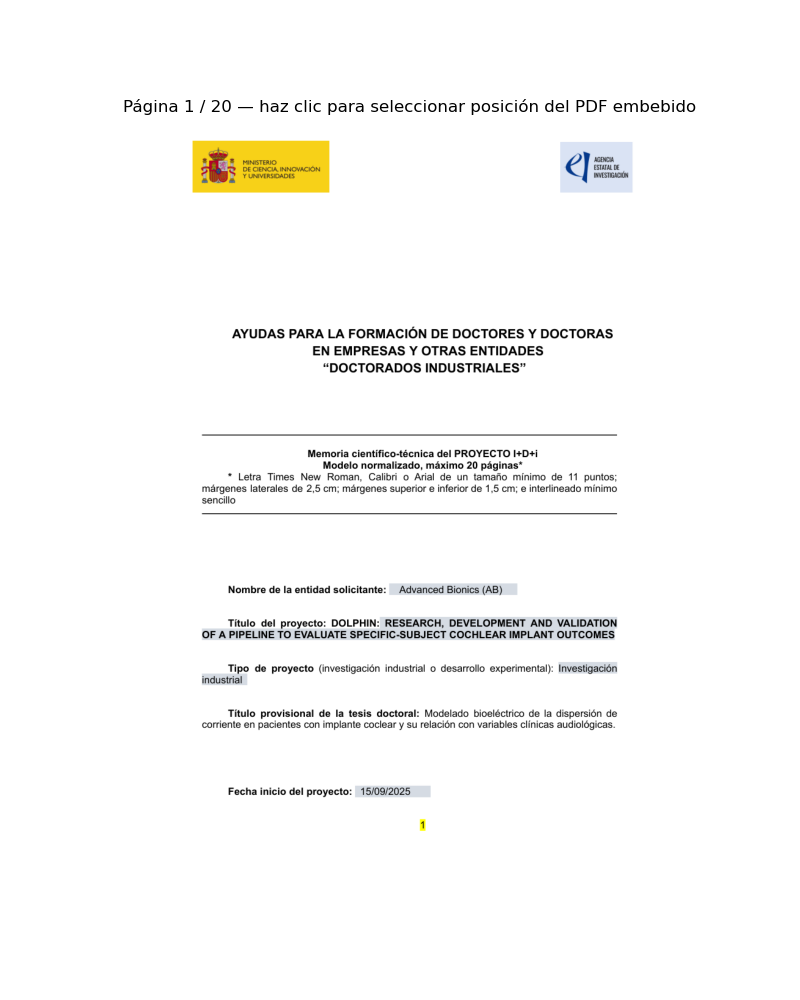

In [ ]:
# Crear figura persistente
fig, ax = plt.subplots(figsize=(8, 10))
#plt.subplots_adjust(bottom=0.05, top=0.95)
ax.axis("off")

# Crear botón de confirmación (oculto por defecto)
confirm_button.layout.display = 'none'  # Oculto hasta que haya clic
# Slider para tamaño del rectángulo (previsualización)
size_slider = widgets.IntSlider(value=112, min=64, max=200, step=4, description='Tamaño (pt):')
display(size_slider)
display(confirm_button)
click_coords = None  # Guardar coordenadas del último clic

fig.canvas.mpl_connect("button_press_event", onclick)
confirm_button.on_click(on_confirm)

prev_button = widgets.Button(description="<- Página anterior")
next_button = widgets.Button(description="-> Página siguiente")
prev_button.on_click(on_prev)
next_button.on_click(on_next)

display(prev_button, next_button)
show_page(page_index)